**Table of contents**<a id='toc0_'></a>    
- [The Model](#toc1_)    
  - [Assessing the model's performance](#toc1_1_)    
- [Load all attacks](#toc2_)    
- [Get sentiment scores for all](#toc3_)    
    - [Insomniac Games](#toc3_1_1_)    
    - [WannaCry Attack](#toc3_1_2_)    
    - [SolarWinds Attack](#toc3_1_3_)    
  - [Store the results for usage](#toc3_2_)    
- [Results](#toc4_)    
  - [Distribution of Sentiment Scores and Classes](#toc4_1_)    
  - [Sentiment Scores Over Time - Across Subreddits](#toc4_2_)    
  - [Comparing All Attacks](#toc4_3_)    
    - [Sentiments in first 2 months of attack](#toc4_3_1_)    
  - [Relationship between score and sentiment](#toc4_4_)    
  - [Topics of Discussion](#toc4_5_)    
    - [Most active posts](#toc4_5_1_)    
    - [Wordclouds](#toc4_5_2_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

In [ ]:
import re
import warnings
import nltk
import sqlite3
import torch
import matplotlib
import data_analysis_functions as f
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from scipy.special import softmax
from typing import Tuple, Union
from transformers import pipeline, AutoTokenizer, AutoConfig, AutoModelForSequenceClassification, DistilBertTokenizer, DistilBertForSequenceClassification
from datasets import load_dataset
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, ConfusionMatrixDisplay
from scipy.stats import pearsonr
from tabulate import tabulate

In [ ]:
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.options.mode.chained_assignment = None  # default='warn'

# <a id='toc1_'></a>[The Model](#toc0_)

In [2]:
SENTIMENT_MODEL = "cardiffnlp/twitter-roberta-base-sentiment-latest"
sentiment_tokenizer = AutoTokenizer.from_pretrained(SENTIMENT_MODEL)
sentiment_config = AutoConfig.from_pretrained(SENTIMENT_MODEL)
sentiment_model = AutoModelForSequenceClassification.from_pretrained(SENTIMENT_MODEL)
sentiment_model.eval()

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
             

## <a id='toc1_1_'></a>[Assessing the model's performance](#toc0_)

In [50]:
# Load the Sentiment140 dataset
dataset = load_dataset("sentiment140", split = 'test')
dataset = f.preprocess_test_dataset(dataset)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\seanm\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\seanm\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\seanm\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [51]:
test_texts = dataset["text"]
test_labels = dataset["sentiment"]
# Map sentiment labels from Sentiment140 dataset to match model output classes
def map_sentiment_label(label):
    if label == 0:  # Negative sentiment
        return 0
    elif label == 2:  # Neutral sentiment
        return 1
    elif label == 4:  # Positive sentiment
        return 2
    else:
        raise ValueError("Invalid sentiment label")

# Preprocess sentiment labels in the dataset
test_labels_mapped = [map_sentiment_label(label) for label in test_labels]

In [52]:
# Tokenize the validation or test data
inputs = sentiment_tokenizer(test_texts, return_tensors="pt", padding=True, truncation=True, max_length = 512)
# Forward pass through the model to obtain predictions for validation data
with torch.no_grad():
    outputs = sentiment_model(**inputs)
    logits = outputs.logits
# Convert logits to predicted labels for validation data
pred_labels = torch.argmax(logits, dim=1).tolist()

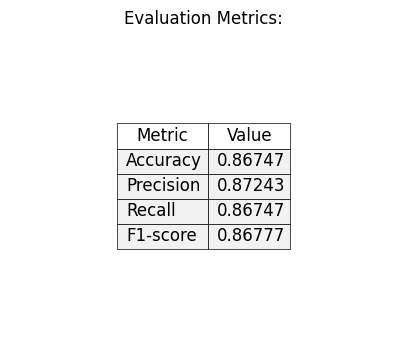

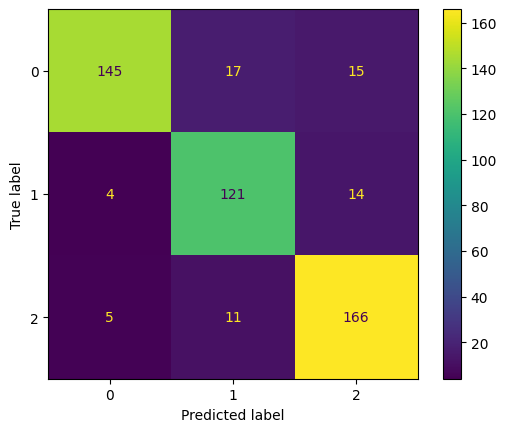

In [53]:
f.evaluate_test_dataset(test_labels_mapped, pred_labels)

# <a id='toc2_'></a>[Load all attacks](#toc0_)

In [58]:
conn = sqlite3.connect("PreProcessed.db")

In [59]:
attacks = pd.read_sql(sql = "select * from attacks",con = conn, index_col = "attack_id" )
attacks

,attack_name
attack_id,
1,Insomniac Games
2,WannaCry
3,SolarWinds


In [60]:
merged_posts, merged_parent_comments, merged_reddit_replies = f.get_all_attacks(conn)

In [61]:
merged_posts

,post_id,subreddit,title,content,score,upvote_ratio,post_datetime,attack_id
rp_index,,,,,,,,
1,18mf8b5,TwoBestFriendsPlay,Statement from Remedy on the Insomniac Games r...,None,505,0.98,1703027019,1
3,18ogglo,pcgaming,Insomniac Games Releases Statement on recent r...,None,630,0.90,1703256167,1
4,18gkw38,SpidermanPS4,"So apparently, Insomniac got hit with a ransom...",None,1584,0.88,1702384490,1
5,18lzgnk,Marvel,Several Insomniac Marvel games and estimate re...,None,208,0.88,1702984282,1
6,1b0m4vj,technology,Insomniac Games alerts employees hit by ransom...,None,62,0.88,1708965991,1
...,...,...,...,...,...,...,...,...
2340,18uxkw6,SpidermanPS4,Insomniac's leaked next game.,None,1685,0.89,1703991538,1
2347,18qiwww,GamingLeaksAndRumours,Insomniac leak: Demand for the remastered games,The same guy shared [the Future of PS Plus](ht...,628,0.93,1703511713,1
2378,7kpiac,politics,US to announce North Korea behind WannaCry cyb...,None,38,0.82,1513643331,2


In [58]:
merged_parent_comments

,parent_comment_id,content,score,comment_datetime,post_id
rc_index,,,,,
1,ke3saoh,personal info getting leaked honestly scary th...,232,1703027544,18mf8b5
2,ke3u1iu,one thing leak game everyone talk leaking priv...,136,1703028248,18mf8b5
3,ke45kdu,sobering reminder people thing criminal howeve...,73,1703032967,18mf8b5
4,ke3xow5,although may strike reader harsh believe nearl...,75,1703029736,18mf8b5
5,ke3xbdr,good insom least receiving support wake whatev...,51,1703029581,18mf8b5
...,...,...,...,...,...
220411,gsow4wk,shocked well really shocked,6,1617028497,mfhuq7
220412,gsq4dj7,started war operation olympic game look stuxne...,1,1617048746,mfhuq7
220413,gspo05b,true blessed incredibly ineffective incapable ...,1,1617041266,mfhuq7


In [59]:
merged_reddit_replies

,reply_id,content,score,comment_datetime,parent_id,post_id
rr_index,,,,,,
1,ke3sw9d,right sympathy hacker sony come got ruin life ...,162,1703027787,ke3saoh,18mf8b5
2,ke4grbb,suck couple reason timing almost christmas peo...,57,1703037616,ke3saoh,18mf8b5
3,ke496do,especially since certain crowd already made mi...,47,1703034454,ke3saoh,18mf8b5
4,ke4tx0q,honestly get hope justice ransomware attack mo...,48,1703043362,ke3saoh,18mf8b5
5,ke47jzq,,-44,1703033783,ke3saoh,18mf8b5
...,...,...,...,...,...,...
629989,gsow4wk,shocked well really shocked,6,1617028497,gsorx9x,mfhuq7
629990,gsq4dj7,started war operation olympic game look stuxne...,1,1617048746,gsorx9x,mfhuq7
629991,gspo05b,true blessed incredibly ineffective incapable ...,1,1617041266,gsorx9x,mfhuq7


In [60]:
insomniac_posts, insomniac_parent_comments, insomniac_reddit_replies = f.get_attack_from_merged(merged_posts, merged_parent_comments, merged_reddit_replies, 1) 

In [61]:
wannacry_posts, wannacry_parent_comments, wannacry_reddit_replies = f.get_attack_from_merged(merged_posts, merged_parent_comments, merged_reddit_replies, 2) 

In [62]:
solarwinds_posts, solarwinds_parent_comments, solarwinds_reddit_replies = f.get_attack_from_merged(merged_posts, merged_parent_comments, merged_reddit_replies, 3) 

# <a id='toc3_'></a>[Get sentiment scores for all](#toc0_)

### <a id='toc3_1_1_'></a>[Insomniac Games](#toc0_)

In [63]:
insomniac_all_comments = f.get_all_comments_df(insomniac_posts, insomniac_parent_comments, insomniac_reddit_replies) 
insomniac_all_comments

,comment_id,content,score,comment_datetime,post_id,subreddit,attack_id
0,ke3saoh,personal info getting leaked honestly scary th...,232,1703027544,18mf8b5,TwoBestFriendsPlay,1
1,ke3u1iu,one thing leak game everyone talk leaking priv...,136,1703028248,18mf8b5,TwoBestFriendsPlay,1
2,ke45kdu,sobering reminder people thing criminal howeve...,73,1703032967,18mf8b5,TwoBestFriendsPlay,1
3,ke3xow5,although may strike reader harsh believe nearl...,75,1703029736,18mf8b5,TwoBestFriendsPlay,1
4,ke3xbdr,good insom least receiving support wake whatev...,51,1703029581,18mf8b5,TwoBestFriendsPlay,1
...,...,...,...,...,...,...,...
7985,kf34vyr,yea make weird decision like would port dr 1 s...,2,1703654426,18qiwww,GamingLeaksAndRumours,1
7986,kex6d52,pp multiplayer p huh eh hoping first party p h...,7,1703547627,18qiwww,GamingLeaksAndRumours,1
7987,kewakw9,10 ps4 version fan newcomer like post suggests,3,1703533479,18qiwww,GamingLeaksAndRumours,1
7988,keypzjt,px remaster,3,1703577602,18qiwww,GamingLeaksAndRumours,1


In [64]:
insomniac_all_comments = f.process_df(insomniac_all_comments, 'content', sentiment_tokenizer, sentiment_config, sentiment_model)

In [65]:
insomniac_all_comments

,comment_id,content,score,comment_datetime,post_id,subreddit,attack_id,sentiment_score,determined_sentiment
0,ke3saoh,personal info getting leaked honestly scary th...,232,1703027544,18mf8b5,TwoBestFriendsPlay,1,-0.885556,negative
1,ke3u1iu,one thing leak game everyone talk leaking priv...,136,1703028248,18mf8b5,TwoBestFriendsPlay,1,-0.840470,negative
2,ke45kdu,sobering reminder people thing criminal howeve...,73,1703032967,18mf8b5,TwoBestFriendsPlay,1,-0.289011,neutral
3,ke3xow5,although may strike reader harsh believe nearl...,75,1703029736,18mf8b5,TwoBestFriendsPlay,1,-0.461533,negative
4,ke3xbdr,good insom least receiving support wake whatev...,51,1703029581,18mf8b5,TwoBestFriendsPlay,1,-0.553312,negative
...,...,...,...,...,...,...,...,...,...
7985,kf34vyr,yea make weird decision like would port dr 1 s...,2,1703654426,18qiwww,GamingLeaksAndRumours,1,-0.332805,neutral
7986,kex6d52,pp multiplayer p huh eh hoping first party p h...,7,1703547627,18qiwww,GamingLeaksAndRumours,1,0.114489,neutral
7987,kewakw9,10 ps4 version fan newcomer like post suggests,3,1703533479,18qiwww,GamingLeaksAndRumours,1,0.019242,neutral
7988,keypzjt,px remaster,3,1703577602,18qiwww,GamingLeaksAndRumours,1,0.168619,neutral


### <a id='toc3_1_2_'></a>[WannaCry Attack](#toc0_)

In [66]:
wannacry_all_comments = f.get_all_comments_df(wannacry_posts, wannacry_parent_comments, wannacry_reddit_replies)
wannacry_all_comments = f.process_df(wannacry_all_comments, 'content', sentiment_tokenizer, sentiment_config, sentiment_model)

In [67]:
wannacry_all_comments

,comment_id,content,score,comment_datetime,post_id,subreddit,attack_id,sentiment_score,determined_sentiment
0,dhvr48z,first thanks many sure whirlwind publicity lac...,3420,1495451975,6cmmdf,IAmA,2,-0.631646,negative
1,dhvrx7q,receive job offering government,2220,1495453860,6cmmdf,IAmA,2,-0.000487,neutral
2,dhvr4pb,px setup spec also software provide best isola...,2178,1495452007,6cmmdf,IAmA,2,0.334703,neutral
3,dhvr463,good resource way learn cyber security,1336,1495451969,6cmmdf,IAmA,2,0.725165,positive
4,dhvs8md,hell ir good work kil switch question 2sec4u g...,1327,1495454550,6cmmdf,IAmA,2,0.865946,positive
...,...,...,...,...,...,...,...,...,...
17350,drhc468,let think poor country barely internet access ...,1,1513706744,7kphs3,worldnews,2,-0.694861,negative
17351,drhd0ss,war sell fuck nuclear proliferation amount cas...,1,1513707674,7kphs3,worldnews,2,-0.821200,negative
17352,drhdi6v,war never sell unless attacked directly n alre...,2,1513708153,7kphs3,worldnews,2,-0.732043,negative
17353,drhmpsd,american public bloodthirsty af show far need ...,2,1513717463,7kphs3,worldnews,2,-0.892421,negative


### <a id='toc3_1_3_'></a>[SolarWinds Attack](#toc0_)

In [68]:
solarwinds_all_comments = f.get_all_comments_df(solarwinds_posts, solarwinds_parent_comments, solarwinds_reddit_replies)
solarwinds_all_comments = f.process_df(solarwinds_all_comments, 'content', sentiment_tokenizer, sentiment_config, sentiment_model)

In [69]:
solarwinds_all_comments

,comment_id,content,score,comment_datetime,post_id,subreddit,attack_id,sentiment_score,determined_sentiment
0,h4tmgo8,god need ner supply chain attack immediately far,46,1626021381,oi6wwa,cybersecurity,3,-0.614974,negative
1,h4tnqbp,great video got lot potential excited see content,17,1626022023,oi6wwa,cybersecurity,3,0.980981,positive
2,h4tqcgt,loved wannacry video excited see one,9,1626023330,oi6wwa,cybersecurity,3,0.982828,positive
3,h4tvwqa,awesome video,4,1626026103,oi6wwa,cybersecurity,3,0.940209,positive
4,h4txnrp,literally looking solar wind doc stored check,3,1626026975,oi6wwa,cybersecurity,3,0.031917,neutral
...,...,...,...,...,...,...,...,...,...
16624,gsow4wk,shocked well really shocked,6,1617028497,mfhuq7,technology,3,-0.840873,negative
16625,gsq4dj7,started war operation olympic game look stuxne...,1,1617048746,mfhuq7,technology,3,-0.234056,neutral
16626,gspo05b,true blessed incredibly ineffective incapable ...,1,1617041266,mfhuq7,technology,3,-0.904313,negative
16627,gsqgnwd,biden done anything,3,1617054551,mfhuq7,technology,3,-0.025591,neutral


## <a id='toc3_2_'></a>[Store the results for usage](#toc0_)
- Majority of processing occurred above, this is for speed of access.
- No queries are required here, so csv will do.

In [70]:
insomniac_all_comments.to_csv('insomniac_all_comments.csv', index=True) 
wannacry_all_comments.to_csv('wannacry_all_comments.csv', index=True)
solarwinds_all_comments.to_csv('solarwinds_all_comments.csv', index=True)

In [3]:
insomniac_all_comments = pd.read_csv('insomniac_all_comments.csv', index_col = 0)  
wannacry_all_comments = pd.read_csv('wannacry_all_comments.csv', index_col = 0)
solarwinds_all_comments = pd.read_csv('solarwinds_all_comments.csv', index_col = 0)

In [4]:
all_comments = pd.concat([insomniac_all_comments, wannacry_all_comments, solarwinds_all_comments])
all_comments

,comment_id,content,score,comment_datetime,post_id,subreddit,attack_id,sentiment_score,determined_sentiment
0,ke3saoh,personal info getting leaked honestly scary th...,232,1703027544,18mf8b5,TwoBestFriendsPlay,1,-0.885556,negative
1,ke3u1iu,one thing leak game everyone talk leaking priv...,136,1703028248,18mf8b5,TwoBestFriendsPlay,1,-0.840470,negative
2,ke45kdu,sobering reminder people thing criminal howeve...,73,1703032967,18mf8b5,TwoBestFriendsPlay,1,-0.289011,neutral
3,ke3xow5,although may strike reader harsh believe nearl...,75,1703029736,18mf8b5,TwoBestFriendsPlay,1,-0.461533,negative
4,ke3xbdr,good insom least receiving support wake whatev...,51,1703029581,18mf8b5,TwoBestFriendsPlay,1,-0.553312,negative
...,...,...,...,...,...,...,...,...,...
16624,gsow4wk,shocked well really shocked,6,1617028497,mfhuq7,technology,3,-0.840873,negative
16625,gsq4dj7,started war operation olympic game look stuxne...,1,1617048746,mfhuq7,technology,3,-0.234056,neutral
16626,gspo05b,true blessed incredibly ineffective incapable ...,1,1617041266,mfhuq7,technology,3,-0.904313,negative
16627,gsqgnwd,biden done anything,3,1617054551,mfhuq7,technology,3,-0.025591,neutral


# <a id='toc4_'></a>[Results](#toc0_)



## <a id='toc4_1_'></a>[Distribution of Sentiment Scores and Classes](#toc0_)

Insomniac Games

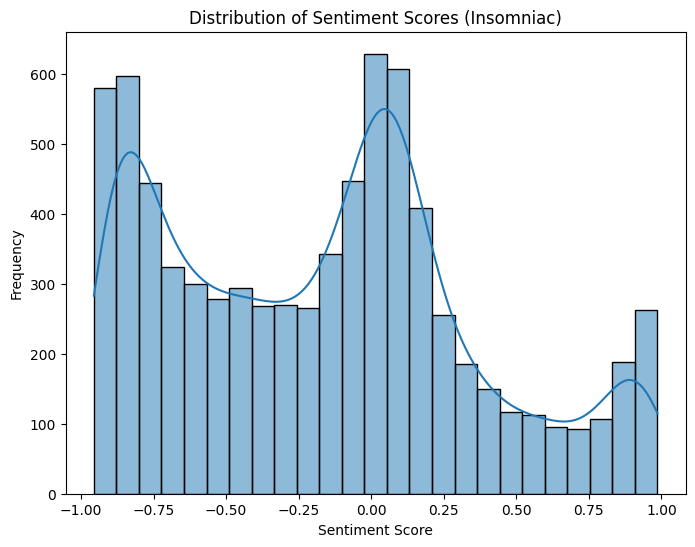

In [5]:
f.display_sentiment_distribution_hist(insomniac_all_comments.copy(), "Insomniac")

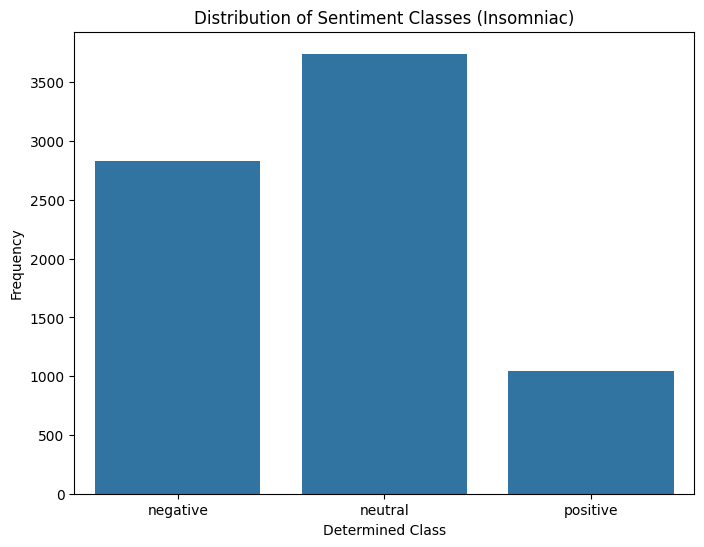

In [6]:
f.display_determined_sentiment_distribution_countplot(insomniac_all_comments.copy(), 'Insomniac')

WannaCry

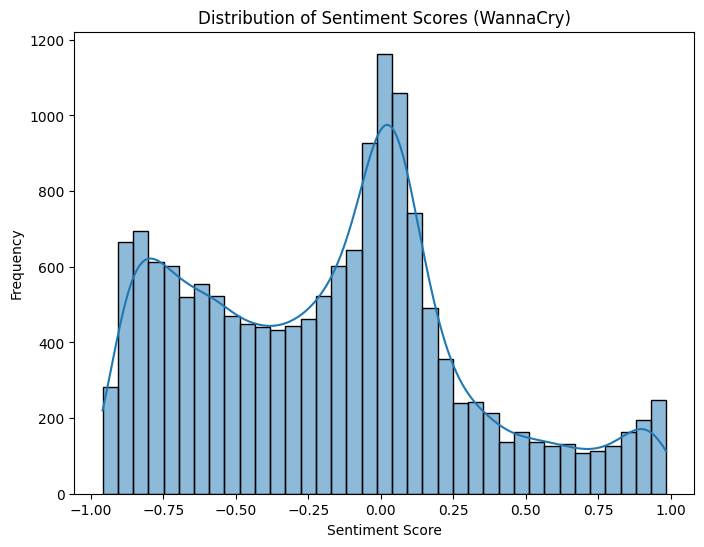

In [7]:
f.display_sentiment_distribution_hist(wannacry_all_comments.copy(), "WannaCry")

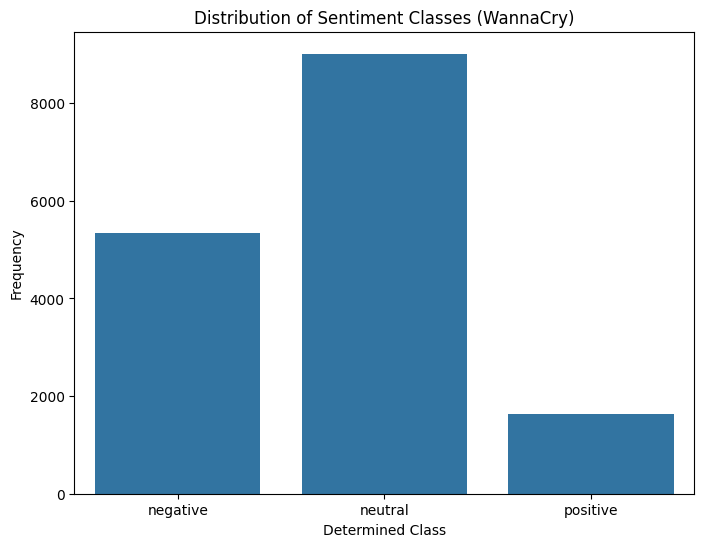

In [8]:
f.display_determined_sentiment_distribution_countplot(wannacry_all_comments.copy(), 'WannaCry')

Solarwinds

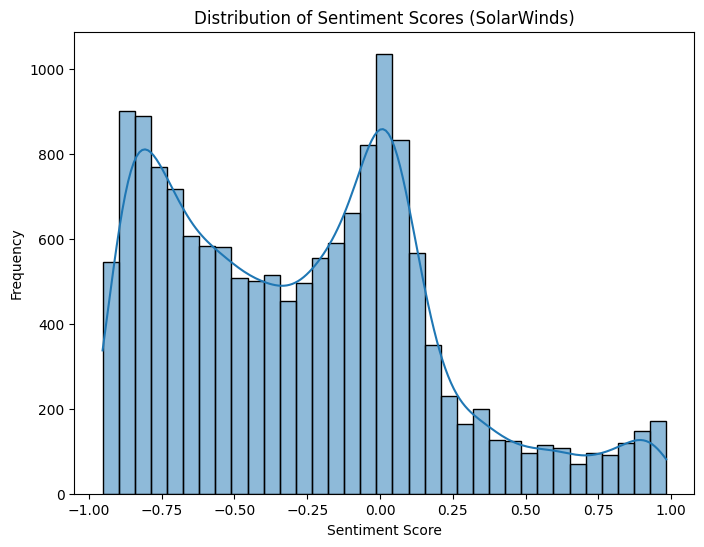

In [9]:
f.display_sentiment_distribution_hist(solarwinds_all_comments.copy(), "SolarWinds")

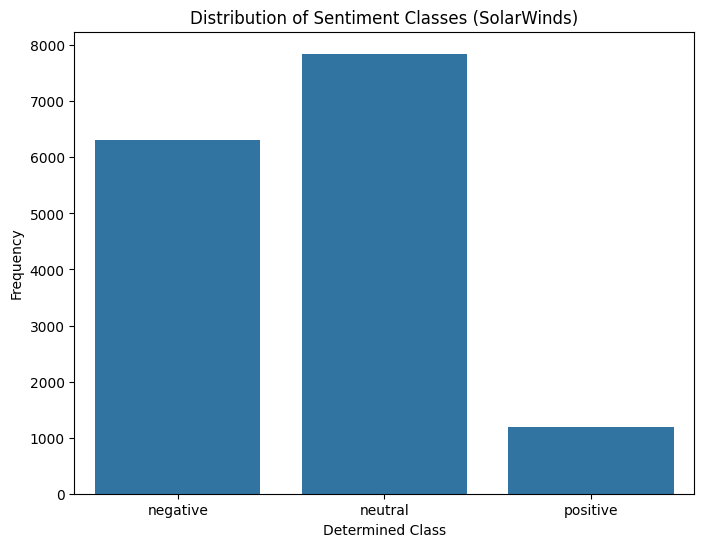

In [10]:
f.display_determined_sentiment_distribution_countplot(solarwinds_all_comments.copy(), 'SolarWinds')

All attacks

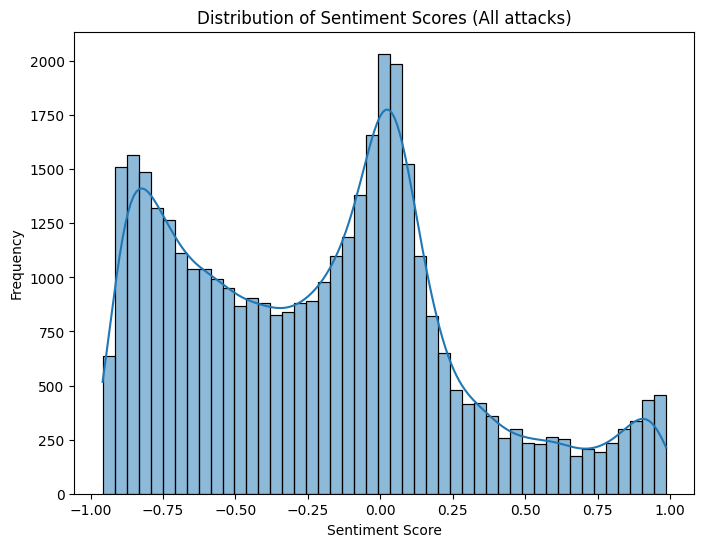

In [11]:
f.display_sentiment_distribution_hist(all_comments.copy(), "All attacks")

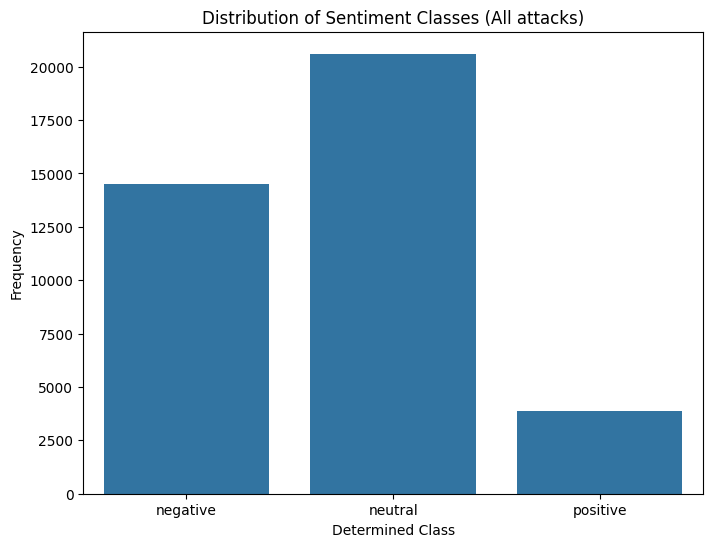

In [12]:
f.display_determined_sentiment_distribution_countplot(all_comments.copy(), 'All attacks')

## <a id='toc4_2_'></a>[Sentiment Scores Over Time - Across Subreddits](#toc0_)

Insomniac Games

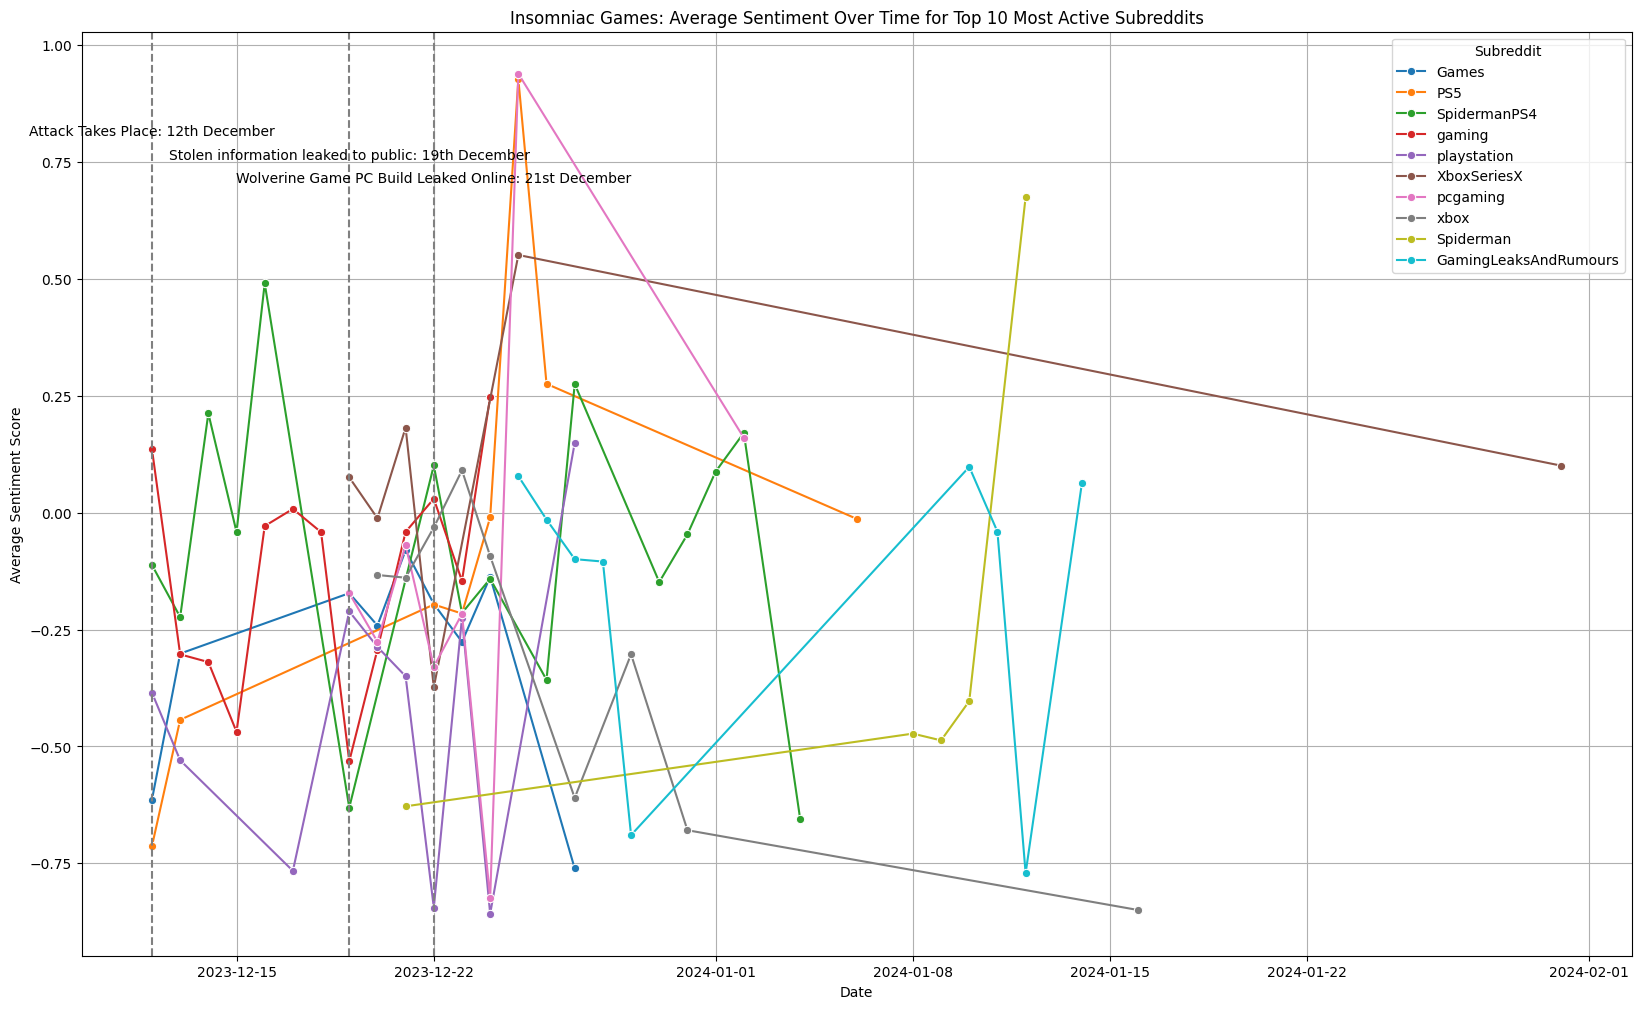

In [39]:
insomniac_dates = {
    '2023-12-12': 'Attack Takes Place: 12th December',
    '2023-12-19': 'Stolen information leaked to public: 19th December',
    '2023-12-22': 'Wolverine Game PC Build Leaked Online: 21st December'
}
f.display_subreddit_sentiment_over_time_line(insomniac_all_comments.copy(), "Insomniac Games", insomniac_dates, filter_period = "3 Month")

WannaCry

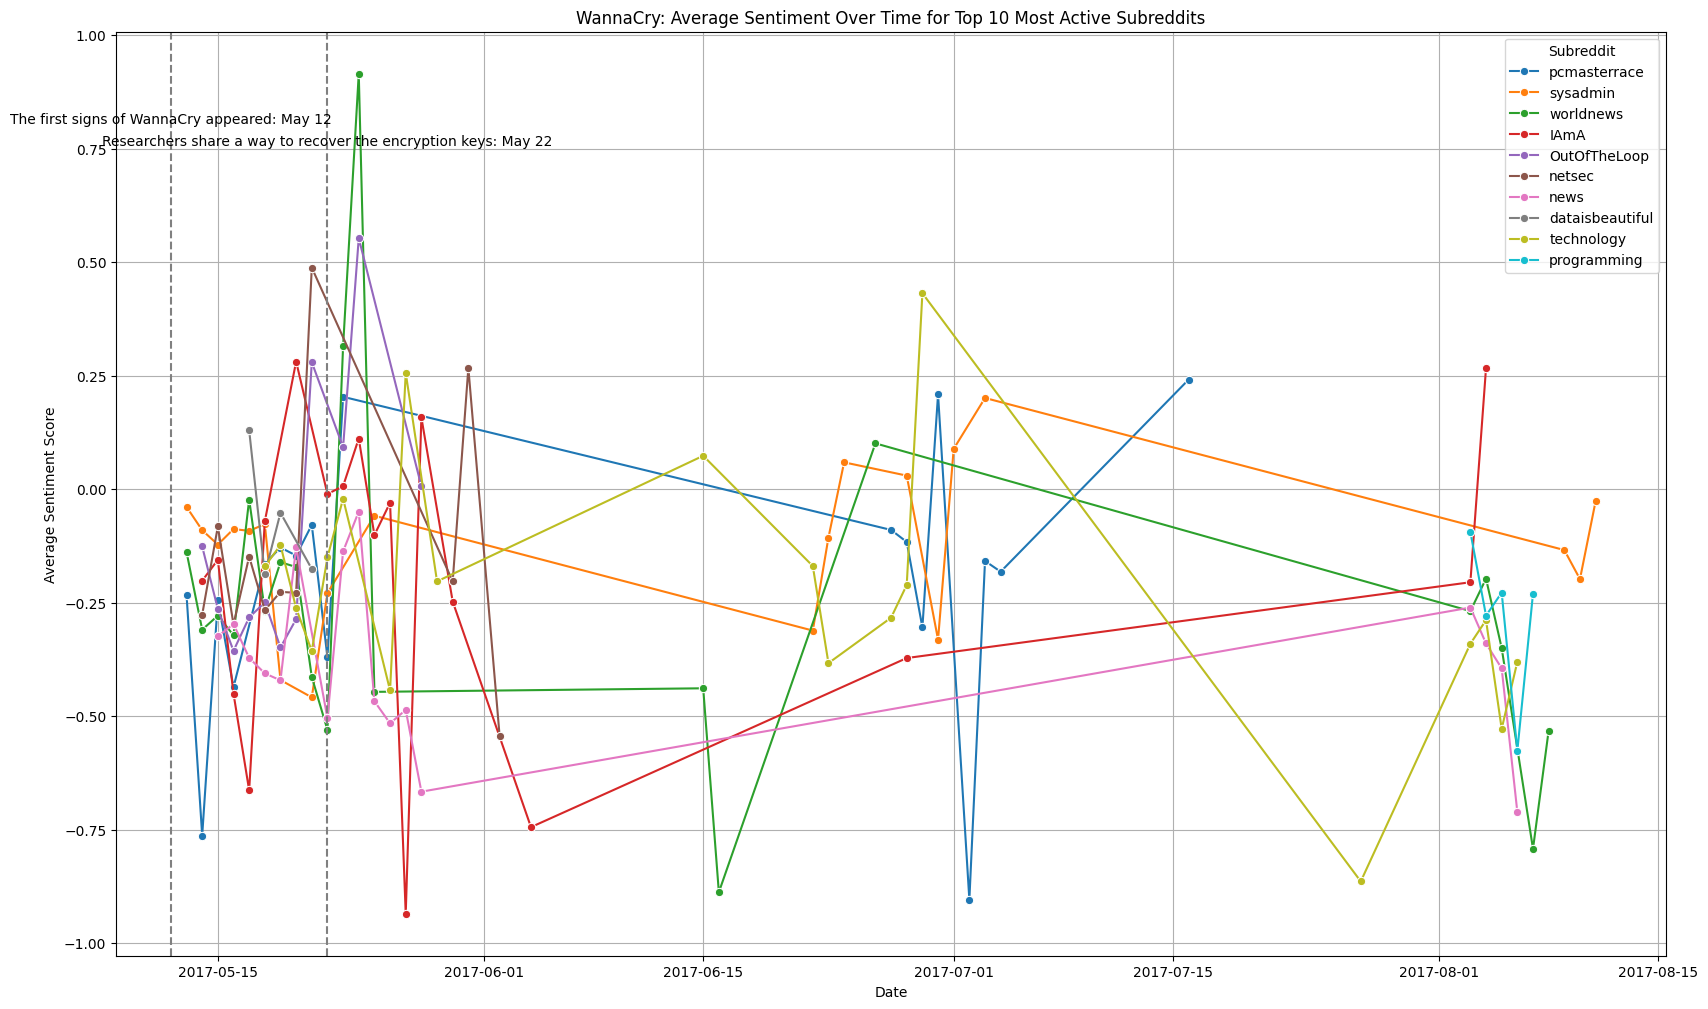

In [36]:
wannacry_dates = {
    '2017-05-12': 'The first signs of WannaCry appeared: May 12',
    '2017-05-22': 'Researchers share a way to recover the encryption keys: May 22'
}
f.display_subreddit_sentiment_over_time_line(wannacry_all_comments.copy(), "WannaCry", wannacry_dates, filter_period = "3 Month")

Solarwinds

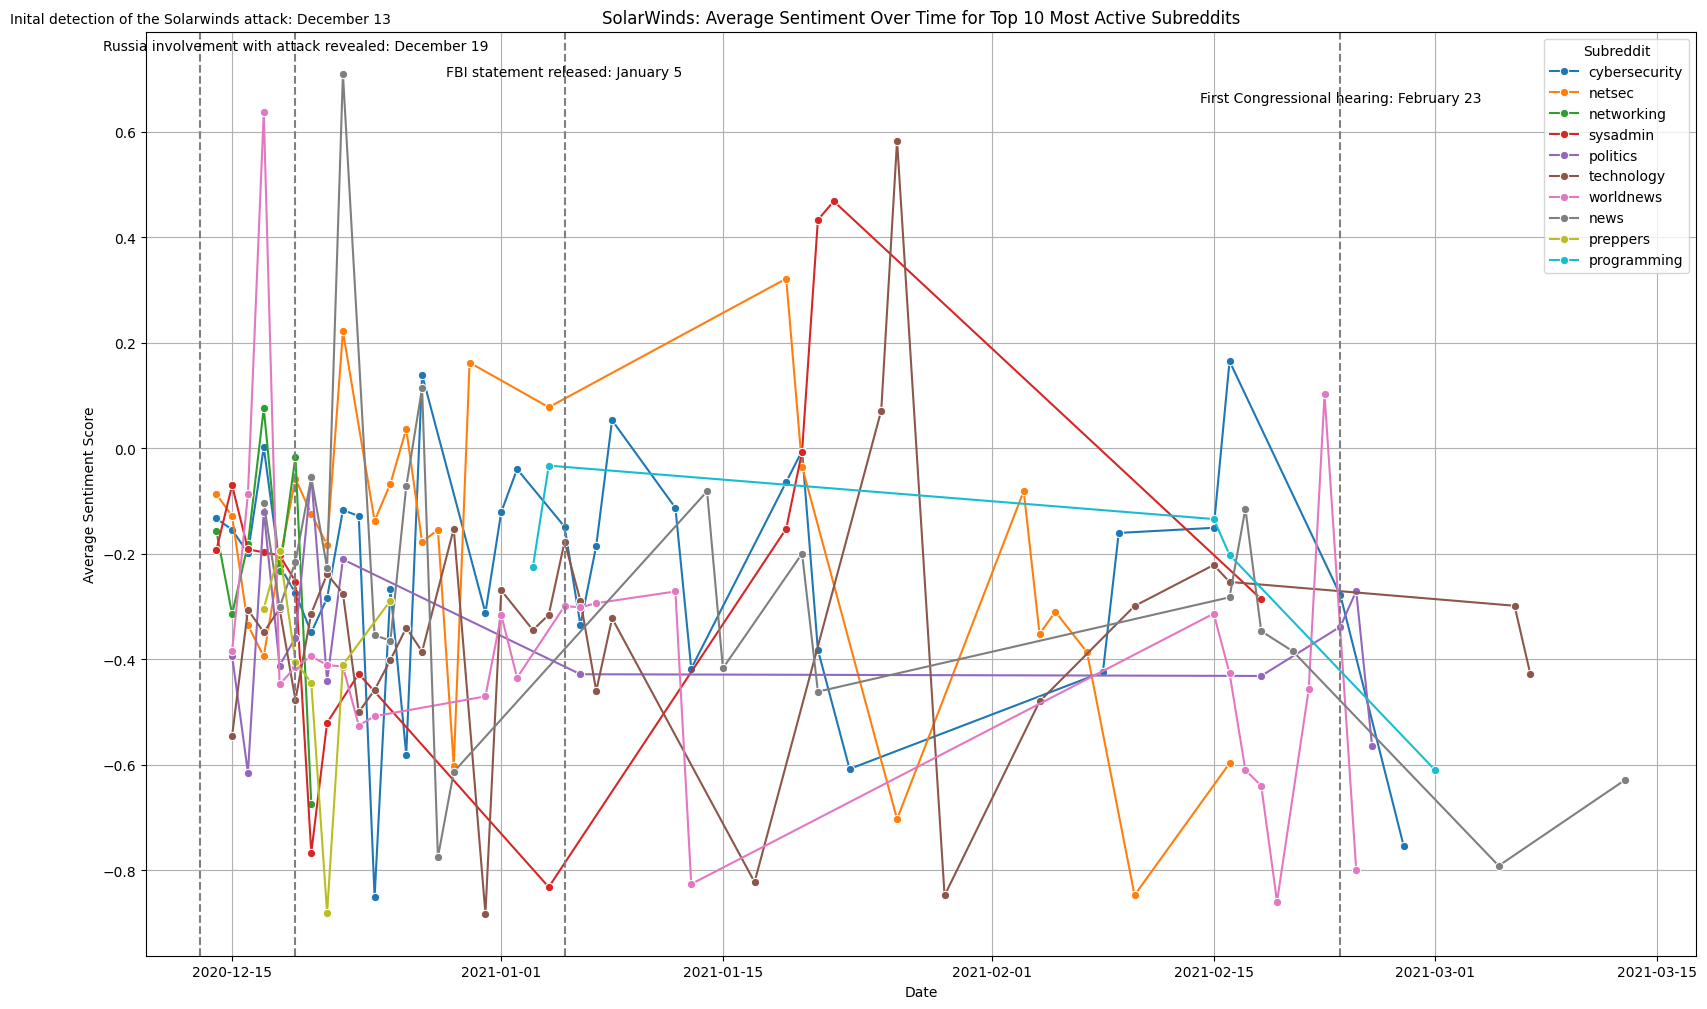

In [38]:
solarwinds_dates = {
    '2020-12-13': 'Inital detection of the Solarwinds attack: December 13',
    '2020-12-19': 'Russia involvement with attack revealed: December 19',
    '2021-01-05': 'FBI statement released: January 5',
    '2021-02-23': 'First Congressional hearing: February 23'
}
f.display_subreddit_sentiment_over_time_line(solarwinds_all_comments.copy(), "SolarWinds", solarwinds_dates, filter_period = "3 Month")

## <a id='toc4_3_'></a>[Comparing All Attacks](#toc0_)


### <a id='toc4_3_1_'></a>[Sentiments in first 2 months of attack](#toc0_)

C:\Users\seanm\AppData\Local\Temp\ipykernel_18656\2809624509.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  attack_data['relative_date'] = (attack_data['comment_datetime'] - filter_start_date).dt.days + 1
C:\Users\seanm\AppData\Local\Temp\ipykernel_18656\2809624509.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  attack_data['relative_date'] = (attack_data['comment_datetime'] - filter_start_date).dt.days + 1
C:\Users\seanm\AppData\Local\Temp\ipykernel_18656\2809624509.py:29: SettingWithCopyWarning

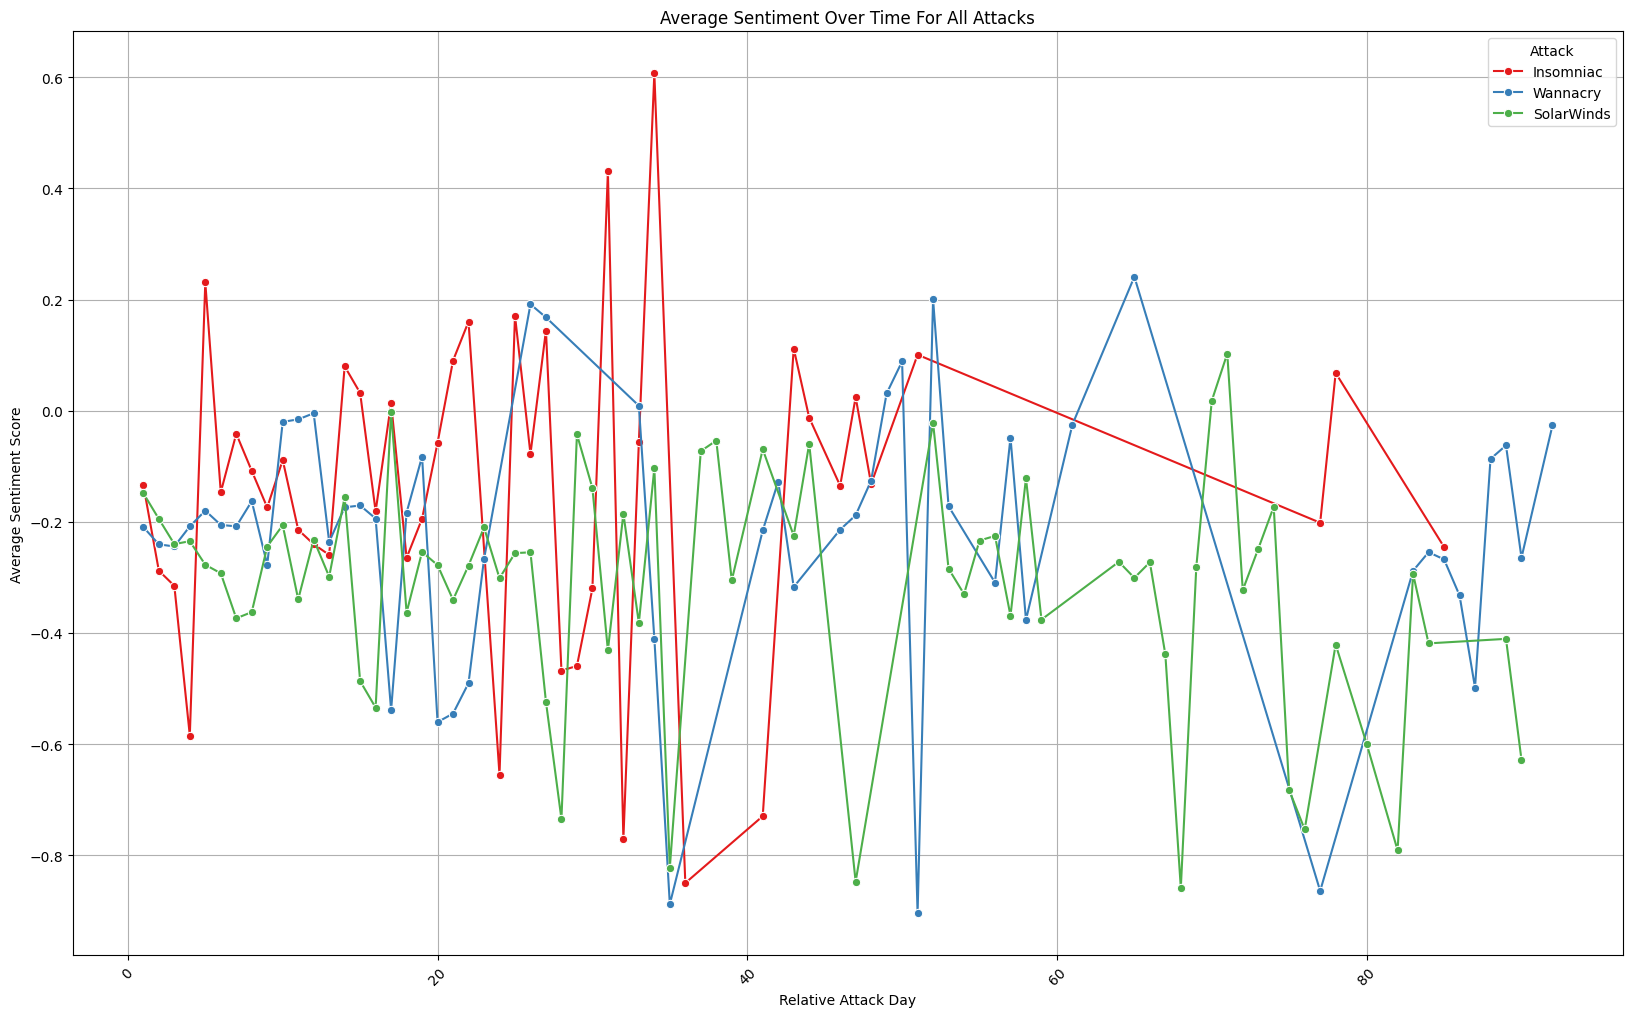

In [43]:
# Insomniac, WannaCry, Solarwinds
start_dates = {'1': '2023-12-12', '2': '2017-05-17','3': '2020-12-01'}
f.compare_avg_sentiment_three_months_line(all_comments.copy(), start_dates)

## <a id='toc4_4_'></a>[Relationship between score and sentiment](#toc0_)

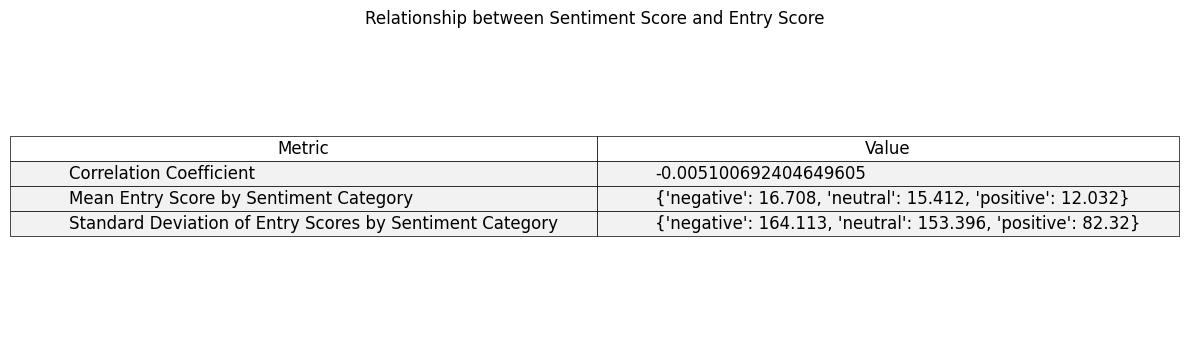


Interpretation:
In conclusion, there is a weak or no relationship between sentiment score and entry score. However, entries with negative sentiment tend to have slightly higher average scores.


In [45]:
f.display_relationship_sentiment_v_score(all_comments.copy())

## <a id='toc4_5_'></a>[Topics of Discussion](#toc0_)

### <a id='toc4_5_1_'></a>[Most active posts](#toc0_)

In [ ]:
pd.set_option('display.max_colwidth', None)

In [83]:
f.get_top_10_active_posts(merged_posts, insomniac_all_comments)

,post_id,comment_count,average_sentiment_score,title
0,18mi5ep,934,-0.132897,"Xbox is not allowed X-Men games until 2036, according to illegally breached Insomniac Games materials"
1,18luxxa,858,-0.180325,"More than a terabyte of Insomniac Games' internal data has been leaked by hacker group, including internal HR documents, 'Wolverine' game files, and timeline of upcoming projects"
2,18n8nws,675,-0.083512,Illegally breached data from Insomniac Games reveals that Xbox is not allowed X-men games until 2036 due to Sony signing a deal with Marvel
3,18hjfx6,536,-0.304509,"Insomniac Games hacked, Wolverine screenshots and employee data stolen - Ransom of 2 Million Dollars"
4,191swtu,500,-0.475445,Insomniac Spider-Man “fans” harassing MJ’s video game model
5,18og8im,395,-0.186226,Insomniac Games releases statement regarding recent leaks
6,18m5g5f,393,0.052479,Insomniac Games Has Made Just $567 off Sunset Overdrive
7,18gkw38,388,-0.128790,"So apparently, Insomniac got hit with a ransomware attack, wolverine got leaked, but there is no DLC or NG+ for SM2 yet"
8,18n8mdj,387,-0.034999,"Xbox is not allowed X-Men games until 2036, according to illegally breached Insomniac Games materials."
9,18og8n0,357,-0.221835,Insomniac Games releases statement regarding recent leaks


In [84]:
f.get_top_10_active_posts(merged_posts, wannacry_all_comments)

,post_id,comment_count,average_sentiment_score,title
0,6cmmdf,2399,-0.005824,"IamA the ""accidental hero"" who helped stop the WannaCry attack AMA!"
1,6b7gd4,2324,-0.323143,Microsoft president blasts NSA for its role in 'WannaCry' computer ransom attack
2,6c495x,1147,-0.164970,WannaCry Ransomware Decryption Tool Released; Unlock Files Without Paying Ransom
3,6b5j9h,1056,-0.161477,[AMA Request] The 22 year old hacker who stopped the recent ransomware attacks on British hospitals.
4,6bacmd,842,-0.107104,WannaCry Megathread
5,6jsxq5,538,-0.252061,Huge cyber attack spreading across the world in potential repeat of 'Wannacry' hack
6,6rg0pj,442,-0.281171,FBI arrests WannaCry hero Marcus Hutchins in Las Vegas over malware claims
7,6rdkoy,402,-0.245931,Researcher Who Stopped WannaCry Ransomware Detained in US After Def Con
8,6b0qa0,377,-0.300400,"It's Not Over, WannaCry 2.0 Ransomware Just Arrived With No 'Kill-Switch'"
9,6bs66v,331,-0.180309,Balance of the bitcoin wallets tied to the WannaCry ransomware attack [OC]


In [85]:
f.get_top_10_active_posts(merged_posts, solarwinds_all_comments)

,post_id,comment_count,average_sentiment_score,title
0,kgwi6h,2012,-0.400253,Biden is considering Russian financial sanctions or other retaliatory action in response to the SolarWinds hack
1,kp942d,1063,-0.343802,SolarWinds hack may be much worse than originally feared
2,lk37qq,1027,-0.332474,SolarWinds hack was 'largest and most sophisticated attack' ever: Microsoft president
3,mrcdah,797,-0.371458,"U.S. to sanction Russia for alleged election interference, SolarWinds hack"
4,kdx0p9,605,-0.329802,"No One Knows How Deep Russia's Hacking Rampage Goes. A supply chain attack against IT company SolarWinds has exposed as many as 18,000 companies to Cozy Bear's attacks."
5,kdvaov,364,-0.116680,SolarWinds use the password 'solarwinds123' on their Update Servers
6,kebhgj,331,-0.259483,SolarWinds writes blog describing open-source software as vulnerable because anyone can update it with malicious code - Ages like fine wine
7,kcrd7y,325,-0.160192,"According to FireEye, SolarWinds Orion platform allegedly compromised by foreign hackers."
8,keo19e,273,-0.300978,Preppers: SolarWinds should be a wake up call for you
9,lkt35u,251,-0.275077,"Microsoft says it found 1,000-plus developers' fingerprints on the SolarWinds attack"


In [86]:
pd.reset_option('display.max_colwidth')

### <a id='toc4_5_2_'></a>[Wordclouds](#toc0_)

Insomniac Games

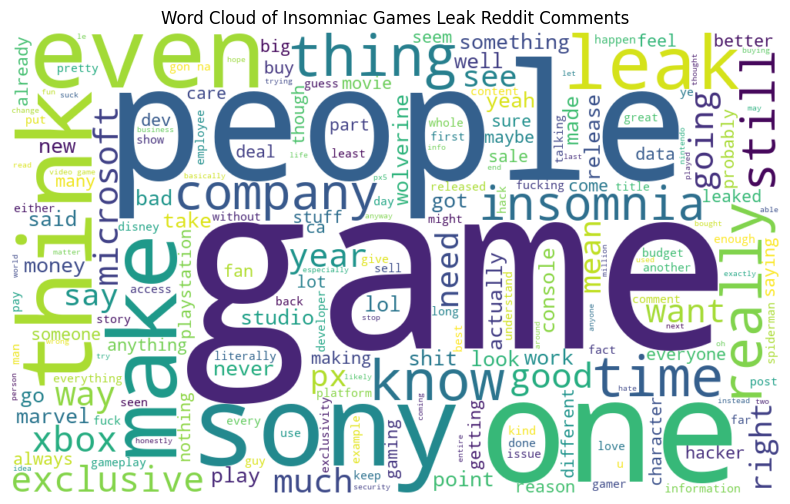

In [56]:
f.display_wordcloud(insomniac_all_comments.copy(), "Insomniac Games Leak Reddit Comments", 'comments')

WannaCry

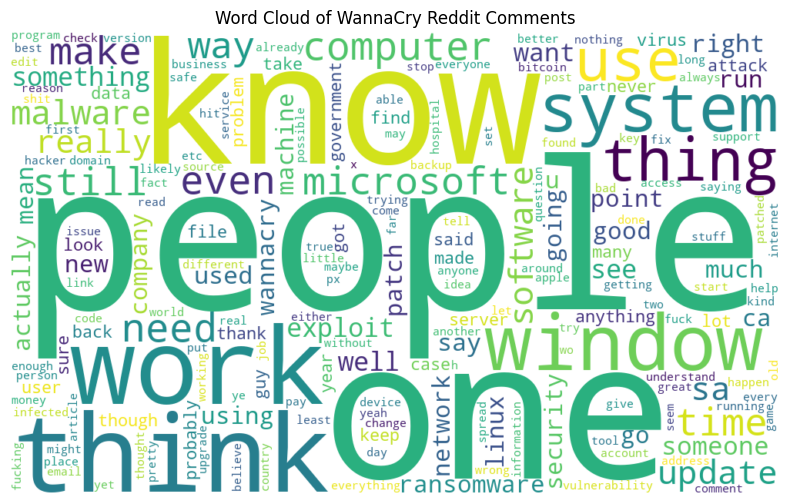

In [18]:
f.display_wordcloud(wannacry_all_comments.copy(), "WannaCry Reddit Comments", 'comments')

SolarWinds

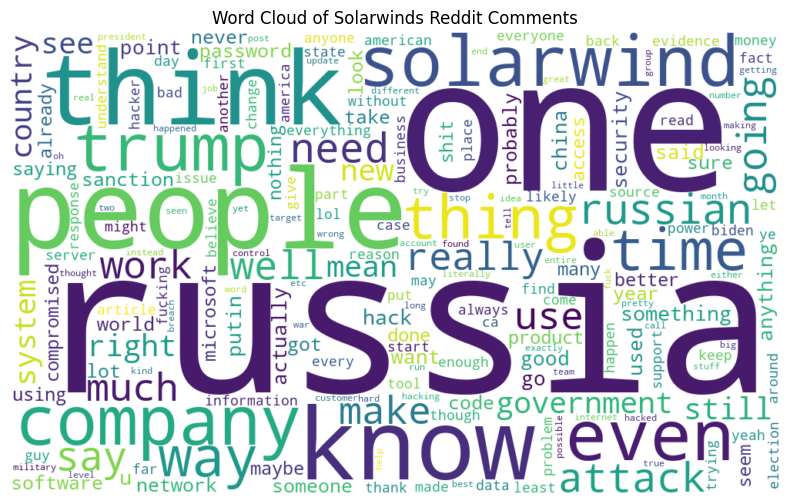

In [19]:
f.display_wordcloud(solarwinds_all_comments.copy(), "Solarwinds Reddit Comments", 'comments')